Connected to ca_tutorial (Python 3.10.11)

 ## Communication evolution over fixed scenes (iterated learning)

 Definition:
 - Meaning is the scene (tower arrangement). It is fixed across generations.
 - Program choices are alternative descriptions of the same scene (different abstraction levels).
 - Compression metrics are program-level proxies (token/step counts), not natural-language length.

 Training protocol:
 - Each generation samples one participant id uniformly.
 - Training uses only the first 5 tower types (10 trials total per participant).

 Test protocol:
 - Test uses the last tower type only (2 trials per participant), on a random subset of participants.
 - Evaluation is frozen (no further learning or chunk promotion).

In [ ]:
import os
import sys
import random
from concurrent.futures import ThreadPoolExecutor
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Set, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

SEED = 42
SHOW_PLOTS = True
USE_PARALLEL = True

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "notebooks_new" else os.path.abspath(os.getcwd())
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

OUT_DIR = os.path.join(ROOT_DIR, "results", "comm")

# Data source under data/model/
SOURCE_SUBDIR = "programs_for_you"

# Tower split: first 5 towers for training (10 trials total), last tower for test (2 trials)
TOWER_ORDER = ["CL", "CPi", "PiC", "LPi", "LC", "PiL"]
TRAIN_TOWERS = set(TOWER_ORDER[:5])
TEST_TOWER = TOWER_ORDER[-1]
TRAIN_NUM_TRIALS_PER_PPT = 10
TEST_NUM_TRIALS_PER_PPT = 2

# Training protocol
NUM_GENERATIONS = 50

# Test protocol
TEST_NUM_PPTS = 10

# Lexicon prior / utterance inventory
LEXEMES = ["blah", "blab", "bloop", "bleep", "floop"]

# RSA parameters
SPEAKER_ALPHA_PROG = 2.0
SPEAKER_ALPHA_UTT = 2.0
SPEAKER_BETA_COST = 0.3
EPSILON = 0.01

# Gate parameters (only used by gated strategic model)
GATE_MIN_ATTEMPTS = 5
GATE_MIN_SUCCESS_RATE = 0.4
GATE_P_INNOVATE = 0.1
GATE_PRE_PROMOTE_CHUNK_CORRECT = 0.6
GATE_MAX_PROMOTE_PER_GEN = 1

# Models to run
MODEL_SPECS = [
    {"model": "learning_agent", "use_gate": False},
    {"model": "strategic_agent", "use_gate": False},
    {"model": "strategic_agent_gate", "use_gate": True},
]

random.seed(int(SEED))
np.random.seed(int(SEED))

# Imports that depend on ROOT_DIR being importable
from model.convention_formation.distribution import LexiconPrior, EmptyDistribution
from model.convention_formation.lexicon import BlockLexicon

In [ ]:

def _softmax_np(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return x
    x = x - float(np.max(x))
    ex = np.exp(x)
    s = float(ex.sum())
    if s <= 0.0:
        return np.ones_like(ex) / float(max(1, len(ex)))
    return ex / s


def _entropy_np(p: np.ndarray) -> float:
    p = np.asarray(p, dtype=float)
    p = p[p > 0.0]
    if p.size == 0:
        return 0.0
    return float(-np.sum(p * np.log(p)))


def _extract_chunks(steps: List[str]) -> Set[str]:
    return {s for s in steps if isinstance(s, str) and s.startswith("chunk")}


def _list_available_ppt_ids(data_dir: str) -> List[int]:
    out: List[int] = []
    for fn in os.listdir(data_dir):
        if not (fn.startswith("programs_ppt_") and fn.endswith(".json")):
                continue
        core = fn[len("programs_ppt_") : -len(".json")]
        try:
            out.append(int(core))
        except ValueError:
            continue
    return sorted(out)


def _trials_path(ppt_id: int) -> str:
    return os.path.join(ROOT_DIR, "data", "model", SOURCE_SUBDIR, f"programs_ppt_{int(ppt_id)}.json")


def load_trials(ppt_id: int) -> pd.DataFrame:
    return pd.read_json(_trials_path(int(ppt_id)))


def split_train_test_trials(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_df = df[df["towers"].isin(TRAIN_TOWERS)].copy()
    test_df = df[df["towers"] == TEST_TOWER].copy()
    if len(train_df) != int(TRAIN_NUM_TRIALS_PER_PPT):
        raise ValueError(f"Expected {TRAIN_NUM_TRIALS_PER_PPT} train trials, got {len(train_df)}.")
    if len(test_df) != int(TEST_NUM_TRIALS_PER_PPT):
        raise ValueError(f"Expected {TEST_NUM_TRIALS_PER_PPT} test trials, got {len(test_df)}.")
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


def build_global_dsl(ppt_ids: List[int]) -> Tuple[List[str], List[str], List[str]]:
    dsl_tokens: Set[str] = set()
    for ppt in ppt_ids:
        df = load_trials(int(ppt))
        train_df, test_df = split_train_test_trials(df)
        for part in (train_df, test_df):
            for dsl_list in part["dsl"].tolist():
                for tok in list(dsl_list):
                    dsl_tokens.add(str(tok))
    full_dsl = sorted(list(dsl_tokens))
    chunks = sorted([t for t in full_dsl if t.startswith("chunk")])
    if len(chunks) > len(list(LEXEMES)):
        raise ValueError(
            "LexiconPrior requires num_chunks <= num_lexemes. "
            f"Got num_chunks={len(chunks)} and num_lexemes={len(list(LEXEMES))}."
        )
    utt_lex = BlockLexicon(full_dsl, list(LEXEMES))
    all_utterances = sorted(list(utt_lex.utterances))
    return full_dsl, chunks, all_utterances

In [ ]:

# Notebook 3 primitives

def B0(utterance: str, lex: BlockLexicon, actions: List[str], epsilon: float) -> EmptyDistribution:
    d = EmptyDistribution()
    intended = lex.language_to_dsl(str(utterance))
    for a in actions:
        d.update({str(a): 1.0 if str(a) == str(intended) else float(epsilon)})
    d.renormalize()
    return d


def A0(intention: str, lex: BlockLexicon, utterances: List[str], epsilon: float) -> EmptyDistribution:
    d = EmptyDistribution()
    expected = lex.dsl_to_language(str(intention))
    for u in utterances:
        d.update({str(u): 1.0 if str(u) == str(expected) else float(epsilon)})
    d.renormalize()
    return d


def update_beliefs_like_notebook3(
    role: str,
    prior: Any,
    observations_df: pd.DataFrame,
    actions: List[str],
    utterances: List[str],
    epsilon: float,
) -> Any:
    if observations_df is None or len(observations_df) == 0:
        return prior.copy()

    posterior = EmptyDistribution()
    posterior.to_logspace()

    for lex in prior.support():
        p0 = float(prior.score(lex))
        prior_term = float(np.log(max(p0, 1e-12)))
        ll = 0.0
        for _, row in observations_df.iterrows():
            utt = str(row["utterance"])
            intent = str(row["intention"])
            resp = str(row["response"])
            if role == "architect":
                ll += float(np.log(B0(utt, lex, actions=actions, epsilon=epsilon).score(resp)))
            else:
                ll += float(np.log(A0(intent, lex, utterances=utterances, epsilon=epsilon).score(utt)))
        posterior.update({lex: prior_term + ll})

    posterior.renormalize()
    posterior.from_logspace()
    return posterior


def expected_inf(
    beliefs: Any,
    utterance: str,
    intention: str,
    actions: List[str],
    epsilon: float,
) -> float:
    total = 0.0
    for lex in beliefs.support():
        pL = float(beliefs.score(lex))
        if pL <= 0.0:
            continue
        total += pL * float(np.log(B0(utterance, lex, actions=actions, epsilon=epsilon).score(intention)))
    return float(total)


def choose_utterance_rsa(
    beliefs: Any,
    utterances: List[str],
    intention: str,
    actions: List[str],
    alpha_utt: float,
    epsilon: float,
    rng: np.random.Generator,
) -> str:
    utt_utils = np.array(
        [expected_inf(beliefs, u, intention, actions=actions, epsilon=epsilon) for u in utterances],
        dtype=float,
    )
    probs = _softmax_np(float(alpha_utt) * utt_utils)
    idx = int(rng.choice(len(utterances), p=probs))
    return str(utterances[idx])


def choose_program_rsa(
    beliefs: Any,
    programs_with_length: Dict[str, int],
    utterances: List[str],
    actions: List[str],
    alpha_prog: float,
    alpha_utt: float,
    beta_cost: float,
    epsilon: float,
    rng: np.random.Generator,
) -> Tuple[str, float]:
    programs = list(programs_with_length.keys())
    if not programs:
        return "", 0.0

    utils: List[float] = []
    for p in programs:
        steps = str(p).split(" ") if p else []
        if not steps:
            utils.append(-1e9)
            continue
        step_vals: List[float] = []
        for step in steps:
            utt_utils = np.array(
                [expected_inf(beliefs, u, step, actions=actions, epsilon=epsilon) for u in utterances],
                dtype=float,
            )
            utt_probs = _softmax_np(float(alpha_utt) * utt_utils)
            step_vals.append(float(np.sum(utt_utils * utt_probs)))
        mean_inf = float(np.mean(step_vals)) if step_vals else -1e9
        util = (1.0 - float(beta_cost)) * mean_inf - float(beta_cost) * float(len(steps))
        utils.append(float(util))

    probs = _softmax_np(float(alpha_prog) * np.array(utils, dtype=float))
    idx = int(rng.choice(len(programs), p=probs))
    return str(programs[idx]), _entropy_np(probs)


def compute_lexeme_mapping_entropy(
    beliefs: Any,
    utterances: List[str],
    actions: List[str],
    epsilon: float,
) -> float:
    if not utterances or not actions:
        return 0.0
    action_list = list(actions)
    entropies: List[float] = []
    for utt in utterances:
        probs = np.zeros(len(action_list), dtype=float)
        for lex in beliefs.support():
            pL = float(beliefs.score(lex))
            if pL <= 0.0:
                continue
            intended = str(lex.language_to_dsl(str(utt)))
            for i, a in enumerate(action_list):
                probs[i] += pL * (1.0 if intended == str(a) else float(epsilon))
        s = float(np.sum(probs))
        if s > 0.0:
            probs = probs / s
        entropies.append(_entropy_np(probs))
    return float(np.mean(entropies)) if entropies else 0.0


def program_level(chosen_program: str, programs_with_length: Dict[str, int]) -> float:
    lengths = [int(v) for v in list(programs_with_length.values())] if programs_with_length else []
    steps = str(chosen_program).split(" ") if chosen_program else []
    L = int(len(steps))
    if not lengths:
        return 0.0
    L_min, L_max = int(min(lengths)), int(max(lengths))
    denom = float(max(1, L_max - L_min))
    return float(L_max - L) / denom


def choose_program_fixed(programs_with_length: Dict[str, int], mode: str = "max") -> str:
    programs = list(programs_with_length.keys())
    if not programs:
        return ""
    if mode == "min":
        return min(programs, key=lambda p: int(programs_with_length.get(p, len(str(p).split(" ")))))
    return max(programs, key=lambda p: int(programs_with_length.get(p, len(str(p).split(" ")))))

Gradual chunk promotion: a gate that filter innovated and stabilized chunk to become reusable, for understandability of listeners.

In [ ]:

# Gate (social stabilization)

class ChunkRegistry:
    def __init__(
        self,
        all_chunks: Set[str],
        min_attempts: int,
        min_success_rate: float,
        p_innovate: float,
        pre_promote_chunk_correct: float,
        max_promote_per_gen: int,
    ) -> None:
        self.all_chunks = set(all_chunks)
        self.min_attempts = int(min_attempts)
        self.min_success_rate = float(min_success_rate)
        self.p_innovate = float(p_innovate)
        self.pre_promote_chunk_correct = float(pre_promote_chunk_correct)
        self.max_promote_per_gen = int(max_promote_per_gen)
        self.active_chunks: Set[str] = set()
        self.candidate_attempts: Dict[str, int] = {}
        self.candidate_successes: Dict[str, int] = {}

    def allowed_chunks_for_episode(self, candidate: Optional[str]) -> Set[str]:
        allowed = set(self.active_chunks)
        if candidate is not None:
            allowed.add(str(candidate))
        return allowed

    def update_candidate(self, chunk: str, attempts: int, successes: int) -> None:
        c = str(chunk)
        self.candidate_attempts[c] = int(self.candidate_attempts.get(c, 0)) + int(attempts)
        self.candidate_successes[c] = int(self.candidate_successes.get(c, 0)) + int(successes)

    def promote(self) -> List[str]:
        eligible: List[Tuple[str, float, int]] = []
        for c, a in list(self.candidate_attempts.items()):
            if c in self.active_chunks:
                continue
            aa = int(a)
            if aa < int(self.min_attempts):
                continue
            ss = int(self.candidate_successes.get(c, 0))
            rate = float(ss) / float(max(1, aa))
            if rate >= float(self.min_success_rate):
                eligible.append((c, rate, aa))
        eligible.sort(key=lambda x: (-x[1], -x[2]))
        promoted: List[str] = []
        k = int(self.max_promote_per_gen)
        for c, _, _ in eligible[: max(0, k)]:
            self.active_chunks.add(c)
            promoted.append(c)
        return promoted

In [ ]:
@dataclass
class ModelState:
    arch_prior: Any
    build_prior: Any
    registry: Optional[ChunkRegistry]
    seen_chunks_used: Set[str]


def simulate_generation(
    trials: pd.DataFrame,
    arch_prior: Any,
    build_prior: Any,
    model_name: str,
    all_utterances: List[str],
    registry: Optional[ChunkRegistry],
    alpha_prog: float,
    alpha_utt: float,
    beta_cost: float,
    epsilon: float,
    rng: np.random.Generator,
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    rows: List[Dict[str, object]] = []
    prog_entropies: List[float] = []
    program_levels: List[float] = []
    chunks_used: Set[str] = set()

    for _, trial in trials.iterrows():
        actions = [str(x) for x in list(trial["dsl"])]
        programs_with_length = {str(k): int(v) for k, v in dict(trial["programs_with_length"]).items()}

        allowed_candidate_chunk: Optional[str] = None
        if model_name == "strategic_agent_gate" and registry is not None and float(registry.p_innovate) > 0.0:
            episode_chunks: Set[str] = set()
            for p in programs_with_length.keys():
                episode_chunks |= _extract_chunks(str(p).split(" ") if p else [])
            pool = sorted(list((registry.all_chunks - set(registry.active_chunks)) & set(episode_chunks)))
            if pool and float(rng.random()) < float(registry.p_innovate):
                allowed_candidate_chunk = str(pool[int(rng.integers(low=0, high=len(pool)))])

            allowed = registry.allowed_chunks_for_episode(allowed_candidate_chunk)
            filtered: Dict[str, int] = {}
            for p, L in programs_with_length.items():
                chunks_p = _extract_chunks(str(p).split(" ") if p else [])
                if chunks_p.issubset(set(allowed)):
                    filtered[str(p)] = int(L)
            if filtered:
                programs_with_length = filtered

        if model_name in {"strategic_agent", "strategic_agent_gate"}:
            chosen_program, ent = choose_program_rsa(
                beliefs=arch_prior,
                programs_with_length=programs_with_length,
                utterances=all_utterances,
                actions=actions,
                alpha_prog=alpha_prog,
                alpha_utt=alpha_utt,
                beta_cost=beta_cost,
                epsilon=epsilon,
                rng=rng,
            )
            prog_entropies.append(float(ent))
        else:
            chosen_program = choose_program_fixed(programs_with_length, mode="max")

        program_levels.append(float(program_level(chosen_program, programs_with_length)))

        steps = str(chosen_program).split(" ") if chosen_program else []
        cand_attempts = 0
        cand_successes = 0

        for step in steps:
            step = str(step)
            is_chunk = bool(step.startswith("chunk"))
            is_active_chunk = bool(registry is not None and step in registry.active_chunks)

            if model_name == "learning_agent":
                utt_dist = arch_prior.marginalize(lambda L: L.dsl_to_language(step))
                utt = str(utt_dist.sample())
            else:
                utt = choose_utterance_rsa(
                    beliefs=arch_prior,
                    utterances=all_utterances,
                    intention=step,
                    actions=actions,
                    alpha_utt=alpha_utt,
                    epsilon=epsilon,
                    rng=rng,
                )

            resp_dist = build_prior.marginalize(lambda L: L.language_to_dsl(utt))
            resp = str(resp_dist.sample())

            # Additional gate-induced difficulty before promotion (only for gated model)
            if registry is not None and model_name == "strategic_agent_gate" and is_chunk and not is_active_chunk:
                ok = bool(float(rng.random()) < float(registry.pre_promote_chunk_correct))
                if ok:
                    resp = step
                else:
                    pool_actions = [a for a in actions if a != step]
                    if pool_actions:
                        resp = str(pool_actions[int(rng.integers(low=0, high=len(pool_actions)))])
                if allowed_candidate_chunk is not None and step == str(allowed_candidate_chunk):
                    cand_attempts += 1
                    cand_successes += 1 if ok else 0

            acc = 1.0 if resp == step else 0.0
            if is_chunk:
                chunks_used.add(step)
            rows.append(
                {
                    "trial": int(trial["trial_num"]),
                    "towers": str(trial["towers"]),
                    "utterance": str(utt),
                    "response": str(resp),
                    "intention": str(step),
                    "target_program": str(chosen_program),
                    "acc": float(acc),
                    "is_chunk": 1.0 if is_chunk else 0.0,
                    "is_active_chunk": 1.0 if is_active_chunk else 0.0,
                }
            )

        if registry is not None and model_name == "strategic_agent_gate" and allowed_candidate_chunk is not None and cand_attempts > 0:
            registry.update_candidate(str(allowed_candidate_chunk), attempts=cand_attempts, successes=cand_successes)

    gen_df = pd.DataFrame(rows)
    acc_comm = float(gen_df["acc"].mean()) if len(gen_df) > 0 else 0.0
    msg_len = (
        float(gen_df.groupby("trial")["target_program"].apply(lambda s: len(str(s.iloc[0]).split(" "))).mean())
        if len(gen_df) > 0
        else 0.0
    )
    frag_rate = float(gen_df["is_chunk"].mean()) if len(gen_df) > 0 else 0.0
    num_active_chunks = float(len(registry.active_chunks)) if registry is not None else 0.0
    program_choice_entropy = float(np.mean(prog_entropies)) if prog_entropies else 0.0
    program_level_mean = float(np.mean(program_levels)) if program_levels else 0.0

    summary: Dict[str, object] = {
        "acc_comm": float(acc_comm),
        "msg_len": float(msg_len),
        "frag_rate": float(frag_rate),
        "num_active_chunks": float(num_active_chunks),
        "program_choice_entropy": float(program_choice_entropy),
        "program_level": float(program_level_mean),
        "chunks_used": "|".join(sorted(list(chunks_used))),
    }
    return gen_df, summary


def run_model(
    model_name: str,
    use_gate: bool,
    ppt_ids: List[int],
    full_dsl: List[str],
    all_utterances: List[str],
    random_seed: int,
    num_generations: int,
    test_num_ppts: int,
) -> pd.DataFrame:
    rng = np.random.default_rng(int(random_seed))

    prior0: Any = LexiconPrior(full_dsl, list(LEXEMES))
    arch_prior: Any = prior0
    build_prior: Any = prior0

    registry: Optional[ChunkRegistry] = None
    if bool(use_gate):
        registry = ChunkRegistry(
            all_chunks=set([t for t in full_dsl if str(t).startswith("chunk")]),
            min_attempts=int(GATE_MIN_ATTEMPTS),
            min_success_rate=float(GATE_MIN_SUCCESS_RATE),
            p_innovate=float(GATE_P_INNOVATE),
            pre_promote_chunk_correct=float(GATE_PRE_PROMOTE_CHUNK_CORRECT),
            max_promote_per_gen=int(GATE_MAX_PROMOTE_PER_GEN),
        )

    seen_chunks_used: Set[str] = set()
    train_rows: List[Dict[str, object]] = []

    for gen in range(int(num_generations)):
        ppt_id = int(rng.choice(np.array(list(ppt_ids), dtype=int)))
        ppt_df = load_trials(int(ppt_id)).copy()
        train_df, _ = split_train_test_trials(ppt_df)

        gen_df, summ = simulate_generation(
            trials=train_df,
            arch_prior=arch_prior,
            build_prior=build_prior,
            model_name=str(model_name),
            all_utterances=all_utterances,
            registry=registry,
            alpha_prog=float(SPEAKER_ALPHA_PROG),
            alpha_utt=float(SPEAKER_ALPHA_UTT),
            beta_cost=float(SPEAKER_BETA_COST),
            epsilon=float(EPSILON),
            rng=rng,
        )

        if registry is not None:
            registry.promote()

        chunks_used_now = set(str(x) for x in str(summ.get("chunks_used", "")).split("|") if str(x))
        reuse_chunk_rate = (
            float(len(chunks_used_now & seen_chunks_used)) / float(max(1, len(chunks_used_now)))
            if len(chunks_used_now) > 0
            else 0.0
        )
        seen_chunks_used |= set(chunks_used_now)

        arch_ent = compute_lexeme_mapping_entropy(arch_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        build_ent = compute_lexeme_mapping_entropy(build_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        lexeme_mapping_entropy = float(arch_ent + build_ent) / 2.0

        train_rows.append(
            {
                "split": "train",
                "generation": float(gen),
                "ppt_id": float(ppt_id),
                "model": str(model_name),
                "acc_comm": float(summ["acc_comm"]),
                "msg_len": float(summ["msg_len"]),
                "frag_rate": float(summ["frag_rate"]),
                "num_active_chunks": float(summ["num_active_chunks"]),
                "program_choice_entropy": float(summ["program_choice_entropy"]),
                "lexeme_mapping_entropy": float(lexeme_mapping_entropy),
                "program_level": float(summ["program_level"]),
                "reuse_chunk_rate": float(reuse_chunk_rate),
            }
        )

        arch_prior = update_beliefs_like_notebook3(
            role="architect",
            prior=arch_prior,
            observations_df=gen_df,
            actions=full_dsl,
            utterances=all_utterances,
            epsilon=float(EPSILON),
        )
        build_prior = update_beliefs_like_notebook3(
            role="builder",
            prior=build_prior,
            observations_df=gen_df,
            actions=full_dsl,
            utterances=all_utterances,
            epsilon=float(EPSILON),
        )

    # Frozen evaluation on test set
    test_rng = np.random.default_rng(int(random_seed) + 123)
    test_ppts = [int(x) for x in test_rng.choice(np.array(list(ppt_ids), dtype=int), size=int(test_num_ppts), replace=False)]
    test_rows: List[Dict[str, object]] = []

    eval_registry: Optional[ChunkRegistry] = None
    if registry is not None:
        eval_registry = ChunkRegistry(
            all_chunks=set(registry.all_chunks),
            min_attempts=int(GATE_MIN_ATTEMPTS),
            min_success_rate=float(GATE_MIN_SUCCESS_RATE),
            p_innovate=0.0,
            pre_promote_chunk_correct=float(GATE_PRE_PROMOTE_CHUNK_CORRECT),
            max_promote_per_gen=0,
        )
        eval_registry.active_chunks = set(registry.active_chunks)

    for ppt in test_ppts:
        ppt_df = load_trials(int(ppt)).copy()
        _, test_df = split_train_test_trials(ppt_df)
        gen_df_eval, summ_eval = simulate_generation(
            trials=test_df,
            arch_prior=arch_prior,
            build_prior=build_prior,
            model_name=str(model_name),
            all_utterances=all_utterances,
            registry=eval_registry,
            alpha_prog=float(SPEAKER_ALPHA_PROG),
            alpha_utt=float(SPEAKER_ALPHA_UTT),
            beta_cost=float(SPEAKER_BETA_COST),
            epsilon=float(EPSILON),
            rng=test_rng,
        )

        arch_ent = compute_lexeme_mapping_entropy(arch_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        build_ent = compute_lexeme_mapping_entropy(build_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        lexeme_mapping_entropy = float(arch_ent + build_ent) / 2.0

        test_rows.append(
            {
                "split": "test",
                "generation": float(num_generations),
                "ppt_id": float(ppt),
                "model": str(model_name),
                "acc_comm": float(summ_eval["acc_comm"]),
                "msg_len": float(summ_eval["msg_len"]),
                "frag_rate": float(summ_eval["frag_rate"]),
                "num_active_chunks": float(summ_eval["num_active_chunks"]),
                "program_choice_entropy": float(summ_eval["program_choice_entropy"]),
                "lexeme_mapping_entropy": float(lexeme_mapping_entropy),
                "program_level": float(summ_eval["program_level"]),
                "reuse_chunk_rate": 0.0,
            }
        )

    out = pd.concat([pd.DataFrame(train_rows), pd.DataFrame(test_rows)], ignore_index=True)
    return out


def _run_worker(job: Dict[str, object]) -> pd.DataFrame:
    return run_model(
        model_name=str(job["model"]),
        use_gate=bool(job["use_gate"]),
        ppt_ids=list(job["ppt_ids"]),
        full_dsl=list(job["full_dsl"]),
        all_utterances=list(job["all_utterances"]),
        random_seed=int(job["random_seed"]),
        num_generations=int(job["num_generations"]),
        test_num_ppts=int(job["test_num_ppts"]),
    )


def run_all_models() -> pd.DataFrame:
    os.makedirs(OUT_DIR, exist_ok=True)
    data_dir = os.path.join(ROOT_DIR, "data", "model", SOURCE_SUBDIR)
    ppt_ids = _list_available_ppt_ids(data_dir)
    if not ppt_ids:
        raise ValueError(f"No participant files found under {data_dir}.")

    full_dsl, _, all_utterances = build_global_dsl(ppt_ids)

    jobs: List[Dict[str, object]] = []
    for spec in MODEL_SPECS:
        jobs.append(
            {
                "model": str(spec["model"]),
                "use_gate": bool(spec["use_gate"]),
                "ppt_ids": list(ppt_ids),
                "full_dsl": list(full_dsl),
                "all_utterances": list(all_utterances),
                "random_seed": int(SEED) + (7 if str(spec["model"]) == "strategic_agent_gate" else 0),
                "num_generations": int(NUM_GENERATIONS),
                "test_num_ppts": int(TEST_NUM_PPTS),
            }
        )

    if USE_PARALLEL:
        with ThreadPoolExecutor(max_workers=min(3, len(jobs))) as pool:
            dfs = list(pool.map(_run_worker, jobs))
    else:
        dfs = [_run_worker(j) for j in jobs]

    out = pd.concat(dfs, ignore_index=True)
    out.to_csv(os.path.join(OUT_DIR, "comm_by_gen.csv"), index=False)
    return out

In [ ]:
comm_df = run_all_models()

### per generation metrics:

acc_comm: Communication accuracy mean(response == intention)

msg_len: Mean message length per communicated program.

frag_rate: Chunk abstractions rate.

program_level: $\text{program\_level}=\frac{L_{\max}-L_{\text{chosen}}}{\max(1,\;L_{\max}-L_{\min})}.$

program_choice_entropy: Measure of confidence $H=-\sum_{p\in\mathcal{P}} P(p)\log P(p).$, of softmax over candidate programs.

lexeme_mapping_entropy: Just as above, $H=-\sum_a P(a\mid u)\log P(a\mid u),$ and average over utterances of each gen.



In [ ]:

analysis_models = ["learning_agent", "strategic_agent"]
train_sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"].isin(analysis_models))]
summary = train_sub.groupby("model")[["acc_comm", "msg_len", "frag_rate", "program_level"]].agg(["mean", "min", "max"])
print(summary)

                 acc_comm                msg_len             frag_rate  \
                     mean       min  max    mean   min   max      mean   
model                                                                    
learning_agent   1.000000  1.000000  1.0  13.600  13.6  13.6  0.000000   
strategic_agent  0.883073  0.757576  1.0   7.264   6.6   8.9  0.179954   

                                   program_level                 
                     min       max          mean       min  max  
model                                                            
learning_agent   0.00000  0.000000      0.000000  0.000000  0.0  
strategic_agent  0.11236  0.212121      0.664788  0.510101  0.7  


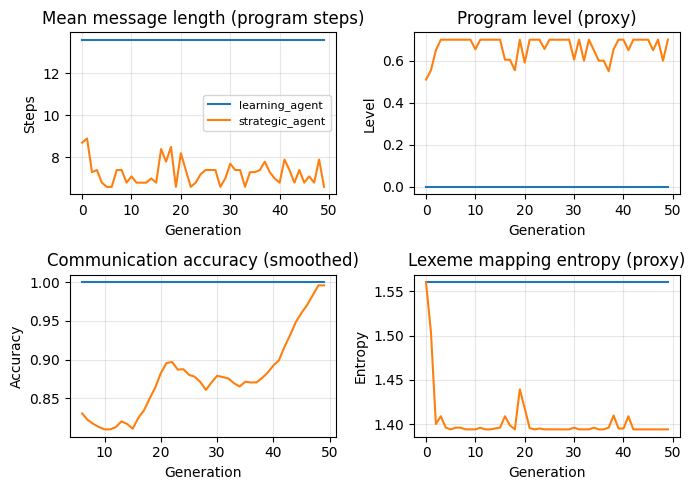

In [ ]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(7, 5))

    for mode in analysis_models:
        sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"] == mode)]
        axes[0, 0].plot(sub["generation"], sub["msg_len"], label=mode)
        axes[0, 1].plot(sub["generation"], sub["program_level"], label=mode)
        axes[1, 0].plot(sub["generation"], pd.Series(sub["acc_comm"]).rolling(window=7).mean(), label=mode)
        axes[1, 1].plot(sub["generation"], sub["lexeme_mapping_entropy"], label=mode)

    axes[0, 0].set_xlabel("Generation")
    axes[0, 0].set_ylabel("Steps")
    axes[0, 0].set_title("Mean message length (program steps)")
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].grid(alpha=0.3)

    axes[0, 1].set_xlabel("Generation")
    axes[0, 1].set_ylabel("Level")
    axes[0, 1].set_title("Program level (proxy)")
    axes[0, 1].grid(alpha=0.3)

    axes[1, 0].set_xlabel("Generation")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].set_title("Communication accuracy (smoothed)")
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].set_xlabel("Generation")
    axes[1, 1].set_ylabel("Entropy")
    axes[1, 1].set_title("Lexeme mapping entropy (proxy)")
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

### Plots on training performance, print metrics on testing results to validate generalization.

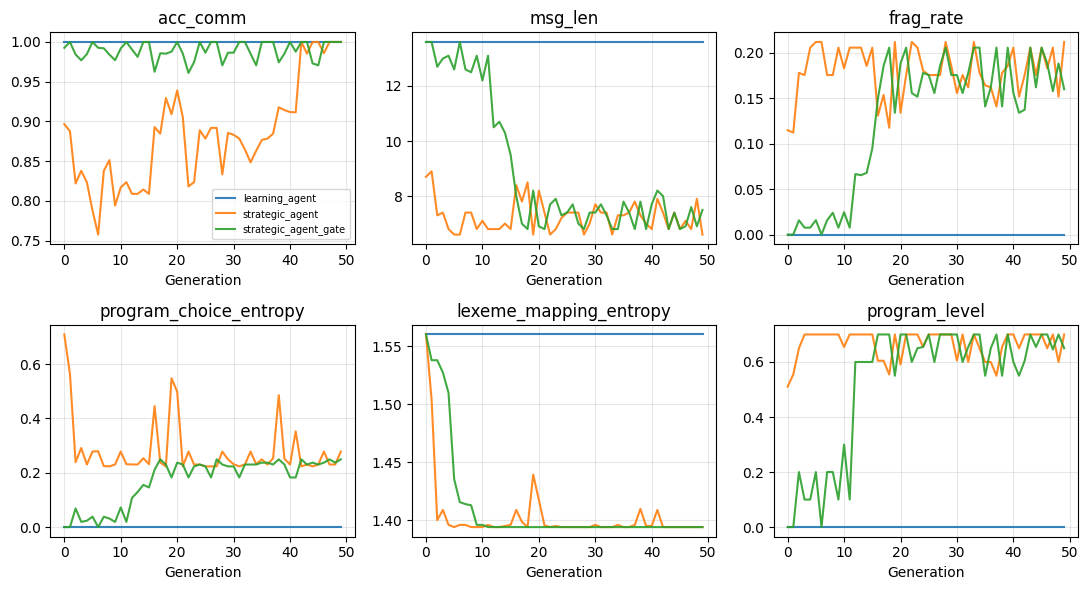

                      acc_comm                msg_len             frag_rate  \
                          mean       min  max    mean   min   max      mean   
model                                                                         
learning_agent        1.000000  1.000000  1.0   14.00  14.0  14.0  0.000000   
strategic_agent       1.000000  1.000000  1.0    5.25   3.0   8.5  0.414146   
strategic_agent_gate  0.985714  0.928571  1.0    6.95   3.0   9.5  0.240606   

                                         program_level            \
                           min       max          mean  min  max   
model                                                              
learning_agent        0.000000  0.000000      0.000000  0.0  0.0   
strategic_agent       0.117647  0.666667      0.950000  0.5  1.0   
strategic_agent_gate  0.105263  0.666667      0.904545  0.5  1.0   

                     lexeme_mapping_entropy                      
                                       mean       

In [ ]:
# Final comparison (includes gated variant)
if SHOW_PLOTS:
    final_models = ["learning_agent", "strategic_agent", "strategic_agent_gate"]
    fig, axes = plt.subplots(2, 3, figsize=(11, 6))
    axes = axes.reshape(2, 3)

    for j, metric in enumerate(["acc_comm", "msg_len", "frag_rate"]):
        ax = axes[0, j]
        for mode in final_models:
            sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"] == mode)]
            ax.plot(sub["generation"], sub[metric], label=mode, alpha=0.9)
        ax.set_title(metric)
        ax.grid(alpha=0.3)
        ax.set_xlabel("Generation")

    for j, metric in enumerate(["program_choice_entropy", "lexeme_mapping_entropy", "program_level"]):
        ax = axes[1, j]
        for mode in final_models:
            sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"] == mode)]
            ax.plot(sub["generation"], sub[metric], label=mode, alpha=0.9)
        ax.set_title(metric)
        ax.grid(alpha=0.3)
        ax.set_xlabel("Generation")

    axes[0, 0].legend(fontsize=7)
    plt.tight_layout()
    plt.show()

    test_summary = comm_df[comm_df["split"] == "test"].groupby("model")[
        ["acc_comm", "msg_len", "frag_rate", "program_level", "lexeme_mapping_entropy"]
    ].agg(["mean", "min", "max"])
    print(test_summary)